# Chapter 2. Small Worlds and Large Worlds

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import lax, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import ELBO, SVI
from numpyro.infer.autoguide import AutoLaplaceApproximation

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

### Code 2.1

In [2]:
ways = jnp.array([0.0, 3, 8, 9, 0])
ways / jnp.sum(ways)

DeviceArray([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)

### Code 2.2

In [3]:
jnp.exp(dist.Binomial(total_count=9, probs=0.5).log_prob(6))

DeviceArray(0.16406302, dtype=float32)

### Code 2.3

In [4]:
# define grid
p_grid = jnp.linspace(start=0, stop=1, num=20)

# define prior
prior = jnp.repeat(1, 20)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

### Code 2.4

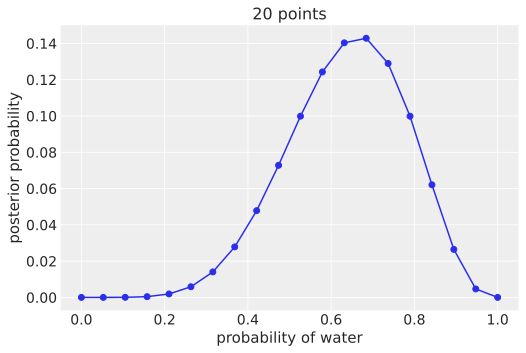

In [5]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("20 points")
plt.show()

### Code 2.5

In [6]:
prior = jnp.where(p_grid < 0.5, 0, 1)
prior = jnp.exp(-5 * abs(p_grid - 0.5))

### Code 2.6

In [7]:
def model(W, L):
    p = numpyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood


guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), ELBO(), W=6, L=3)
init_state = svi.init(random.PRNGKey(0))
state = lax.fori_loop(0, 1000, lambda i, x: svi.update(x)[0], init_state)
params = svi.get_params(state)

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



### Code 2.7

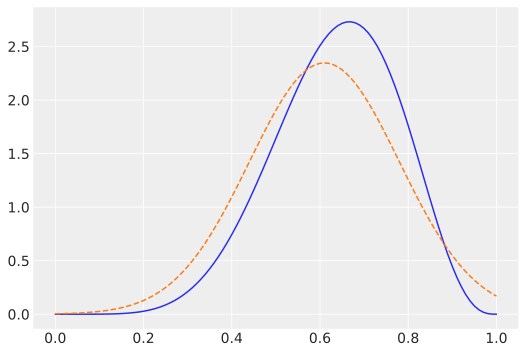

In [8]:
# analytical calculation
W = 6
L = 3
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)))
# quadratic approximation
plt.plot(x, jnp.exp(dist.Normal(0.61, 0.17).log_prob(x)), "--")
plt.show()

### Code 2.8

In [9]:
n_samples = 1000
p = [jnp.nan] * n_samples
p[0] = 0.5
W = 6
L = 3
with numpyro.handlers.seed(rng=0):
    for i in range(1, n_samples):
        p_new = numpyro.sample("p_new", dist.Normal(p[i - 1], 0.1))
        p_new = jnp.abs(p_new) if p_new < 0 else p_new
        p_new = 2 - p_new if p_new > 1 else p_new
        q0 = jnp.exp(dist.Binomial(W + L, p[i - 1]).log_prob(W))
        q1 = jnp.exp(dist.Binomial(W + L, p_new).log_prob(W))
        u = numpyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]

### Code 2.9

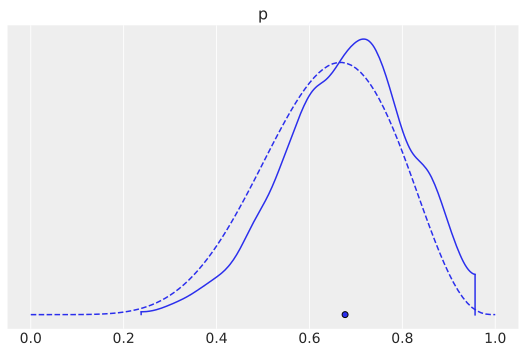

In [10]:
az.plot_density({"p": p}, hdi_prob=1)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)), "--")
plt.show()